(1) Bollinger Bands is a technical analysis tool to generate oversold or overbought signals and was developed by John Bollinger.
(2) Three lines compose Bollinger Bands: A simple moving average, or the middle band, and an upper and lower band.
(3) The upper and lower bands are typically 2 standard deviations +/- from a 20-day simple moving average and can be modified.
(4) When the price continually touches the upper Bollinger Band, it can indicate an overbought signal.
(5) If the price continually touches the lower band it can indicate an oversold signal.

In [39]:
import pandas as pd
import yfinance as yf

#dfSPY = pd.read_csv("SPY.USUSD_Candlestick_1_D_BID_16.02.2017-21.05.2022.csv")
dfSPY=yf.download("^GSPC",start='2011-01-05', end='2021-01-05')
#dfSPY=yf.download("^RUI",start='2011-01-05', end='2021-01-05')
#dfSPY=yf.download("EURUSD=X",start='2011-01-05', end='2021-01-05')

dfSPY=dfSPY[dfSPY.High!=dfSPY.Low]
dfSPY.reset_index(inplace=True)
#dfSPY.head()

/Users/royzheng/workArea/workspace/trading/.venv/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning:

The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.

[*********************100%%**********************]  1 of 1 completed


In [37]:
len(dfSPY)

2317

In [40]:
import pandas_ta as ta
dfSPY['EMA']=ta.sma(dfSPY.Close, length=200)#sma ema, both are fine, no big difference
dfSPY['RSI']=ta.rsi(dfSPY.Close, length=2)
#dfSPY.ta.indicators()
#help(ta.bbands)
my_bbands = ta.bbands(dfSPY.Close, length=20, std=2.5)
my_bbands[0:50]
dfSPY=dfSPY.join(my_bbands)
# Drop samples that are not in 200 ma window
dfSPY.dropna(inplace=True)
dfSPY.reset_index(inplace=True)
#dfSPY

In [41]:
def addemasignal(df, backcandles):
    emasignal = [0]*len(df)
    for row in range(backcandles, len(df)):
        upt = 1
        dnt = 1
        for i in range(row-backcandles, row+1):
            if df.High[i]>=df.EMA[i]:
                dnt=0
            if df.Low[i]<=df.EMA[i]:
                upt=0
        if upt==1 and dnt==1:
            #print("!!!!! check trend loop !!!!")
            emasignal[row]=3
        elif upt==1:
            emasignal[row]=2
        elif dnt==1:
            emasignal[row]=1
    df['EMASignal'] = emasignal

# Use previous 6 days as backcandles
addemasignal(dfSPY, 6)

In [42]:
def addorderslimit(df, percent):
    ordersignal=[0]*len(df)
    for i in range(1, len(df)): #EMASignal of previous candle!!! modified!!!
        # if it's uptrend and closing price is below lower BB
        if df.EMASignal[i]==2 and df.Close[i]<=df['BBL_20_2.5'][i]:# and df.RSI[i]<=100: #Added RSI condition to avoid direct close condition
            ordersignal[i]=df.Close[i]-df.Close[i]*percent

        # if it's downtrend and closing price is above upper BB
        elif df.EMASignal[i]==1 and df.Close[i]>=df['BBU_20_2.5'][i]:# and df.RSI[i]>=0:
            ordersignal[i]=df.Close[i]+df.Close[i]*percent
    df['ordersignal']=ordersignal
    
addorderslimit(dfSPY, 0.00)

In [43]:
#dfSPY[dfSPY.ordersignal!=0]

# Visualization

In [28]:
import numpy as np
def pointposbreak(x):
    if x['ordersignal']!=0:
        return x['ordersignal']
    else:
        return np.nan
dfSPY['pointposbreak'] = dfSPY.apply(lambda row: pointposbreak(row), axis=1)

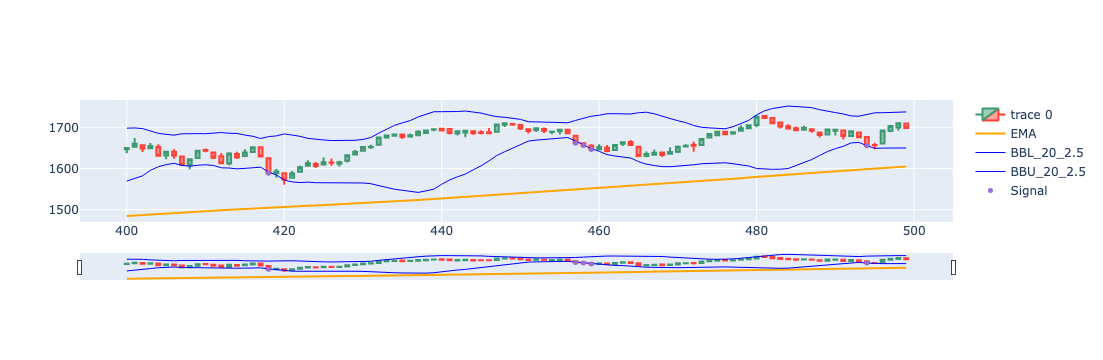

In [29]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime

dfpl = dfSPY[400:500].copy()
#dfpl=dfpl.drop(columns=['level_0'])#!!!!!!!!!!
#dfpl.reset_index(inplace=True)
fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close']),
                go.Scatter(x=dfpl.index, y=dfpl.EMA, line=dict(color='orange', width=2), name="EMA"),
                go.Scatter(x=dfpl.index, y=dfpl['BBL_20_2.5'], line=dict(color='blue', width=1), name="BBL_20_2.5"),
                go.Scatter(x=dfpl.index, y=dfpl['BBU_20_2.5'], line=dict(color='blue', width=1), name="BBU_20_2.5")])

fig.add_scatter(x=dfpl.index, y=dfpl['pointposbreak'], mode="markers",
                marker=dict(size=5, color="MediumPurple"),
                name="Signal")
fig.show()

In [30]:
dfpl = dfSPY[:].copy()

# define SIGNAL based on above calculation
def SIGNAL():
    return dfpl.ordersignal

In [32]:
from backtesting import Strategy
from backtesting import Backtest

class MyStrat(Strategy):
    # 99% of equity
    initsize = 0.50
    ordertime=[]
    def init(self):
        super().init()
        self.signal = self.I(SIGNAL)

    def next(self):
        super().next()

        # precondition - only allow one trade at a time
        # define the order limit, if order has been put more than 5 days, cancel it!
        for j in range(0, len(self.orders)):
            #print('!!!!!!!!!!!!!!!!!!!', self.data.index[-1])
            if self.data.index[-1]-self.ordertime[0]>5:#days max to fulfill the order!!!
                #print('----------------------')
                #print(self.orders)
                #print(self.ordertime)
                self.orders[0].cancel()
                self.ordertime.pop(0)   

        # if there is open trade and current trade more than 10 day, close it
        if len(self.trades)>0:
            #print(self.data.index[-1], self.trades)
            if self.data.index[-1]-self.trades[-1].entry_time>=10:
                self.trades[-1].close()
                #print(self.data.index[-1], self.trades[-1].entry_time)

            # if current trade is long and RSI is above 50, close it
            if self.trades[-1].is_long and self.data.RSI[-1]>=50:
                self.trades[-1].close()
            # if current trade is short and RSI is below 50, close it
            elif self.trades[-1].is_short and self.data.RSI[-1]<=50:
                self.trades[-1].close()
        
        if self.signal!=0 and len(self.trades)==0 and self.data.EMASignal==2:
            #Cancel previous orders
            for j in range(0, len(self.orders)):
                self.orders[0].cancel()
                self.ordertime.pop(0)
            #Add new replacement order, limit, 3%
            self.buy(sl=self.signal/2, limit=self.signal, size=self.initsize)
            self.ordertime.append(self.data.index[-1])
        
        elif self.signal!=0 and len(self.trades)==0 and self.data.EMASignal==1:
            #Cancel previous orders
            for j in range(0, len(self.orders)):
                self.orders[0].cancel()
                self.ordertime.pop(0)
            #Add new replacement order
            self.sell(sl=self.signal*2, limit=self.signal, size=self.initsize)
            self.ordertime.append(self.data.index[-1])

bt = Backtest(dfpl, MyStrat, cash=10000, margin=1/10, commission=.00)
stat = bt.run()
stat

/var/folders/8n/fwm2zylj1kgbbkbpp9g9nbkr0000gn/T/ipykernel_1930/512007321.py:58: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Start                                     0.0
End                                    2316.0
Duration                               2316.0
Exposure Time [%]                    3.884333
Equity Final [$]                 27441.599121
Equity Peak [$]                  27441.599121
Return [%]                         174.415991
Buy & Hold Return [%]              205.869168
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                  -28.654346
Avg. Drawdown [%]                   -4.984671
Max. Drawdown Duration                  273.0
Avg. Drawdown Duration                   62.3
# Trades                                 23.0
Win Rate [%]                        91.304348
Best Trade [%]                        2.15289
Worst Trade [%]                     -1.014957
Avg. Trade [%]                    

In [33]:
bt.plot(show_legend=False)

/Users/royzheng/workArea/workspace/trading/.venv/lib/python3.11/site-packages/backtesting/_plotting.py:659: UserWarning:

found multiple competing values for 'toolbar.active_drag' property; using the latest value

/Users/royzheng/workArea/workspace/trading/.venv/lib/python3.11/site-packages/backtesting/_plotting.py:659: UserWarning:

found multiple competing values for 'toolbar.active_scroll' property; using the latest value



GridPlot(id='p1326', ...)

In [33]:
bt.plot(show_legend=False)

/Users/royzheng/workArea/workspace/trading/.venv/lib/python3.11/site-packages/backtesting/_plotting.py:659: UserWarning:

found multiple competing values for 'toolbar.active_drag' property; using the latest value

/Users/royzheng/workArea/workspace/trading/.venv/lib/python3.11/site-packages/backtesting/_plotting.py:659: UserWarning:

found multiple competing values for 'toolbar.active_scroll' property; using the latest value



GridPlot(id='p1326', ...)

In [34]:
# access the trade list 
stat._trades

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,31,419,422,1588.189941,1592.270020,126.482422,0.002569,419,422,3
1,30,458,463,1661.219971,1659.920044,-38.997803,-0.000783,458,463,5
2,30,495,497,1655.449951,1691.089966,1069.200439,0.021529,495,497,2
3,31,569,573,1790.290039,1790.880005,18.288940,0.000330,569,573,4
4,28,699,701,1929.800049,1936.339966,183.117676,0.003389,699,701,2
5,29,742,744,1945.829956,1970.010010,701.221558,0.012427,742,744,2
6,30,793,796,2002.329956,2018.979980,499.500732,0.008315,793,796,3
7,30,851,853,2044.160034,2064.560059,612.000732,0.009980,851,853,2
8,32,928,930,2057.639893,2078.030029,652.484375,0.009909,928,930,2
9,34,1178,1180,2031.449951,2042.689941,382.159668,0.005533,1178,1180,2
